Prepare the Data:
1. Scrape basketball-reference for player game logs
2. Transform the data into (m, 10, 20) game sequences, each game with 20 features.

In [ ]:
#Install the first basketball-reference scraper
pip install basketball-reference-scraper

In [ ]:
#Install the second basketball-reference scraper
pip install basketball_reference_web_scraper

In [ ]:
#IMPORT STATEMENTS
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # supress scikit 'future warnings'
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment
import matplotlib         
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import norm, kurtosis
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import math
import pickle
import random
import copy
from copy import deepcopy
import itertools
from dataclasses import dataclass
import collections
from collections import defaultdict
import random
from typing import Callable, Dict, List, Tuple, TypeVar
import random
import sys
from collections import Counter
#from basketball_reference_scraper import ask_matches
from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc
from basketball_reference_scraper.players import get_stats, get_game_logs, get_player_headshot, get_player_suffix, lookup
import datetime
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Location 
from basketball_reference_web_scraper.data import Outcome 
from basketball_reference_web_scraper.data import OutputType
import pprint 
import csv
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Create a set of all basketball players (NBA) going back about 20 years
entire_player_list = set()
teams = [
         "ATL", "NJN", "BOS", "CHA", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", 
         "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOP", "NYK",
         "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS", "CHO", "BRK"
]
for team in teams:
  for year in range(2000,2022):
    try:
      for player in get_roster(team, year)['PLAYER']:
        entire_player_list.add(player)
    except:
      print(team, year)

print(len(entire_player_list), entire_player_list)

In [ ]:
#A method to create a player's nba-reference id from their name for use in
#getting that player's game log csv
def create_id(player_name):
  player_names = player_name.strip("-_.,\'~`").split(" ")
  first = player_names[0]
  last = player_names[1]
  player_id = last.lower().strip()[0:min(5,len(last))] + first.lower()[0:min(2,len(first))] + "01"
  return player_id


In [ ]:
#A method to save each player's season game logs to a csv in Google Drive for 
#easy future use.
def output_file(player_id, player_name, year):
  try:
    client.regular_season_player_box_scores(player_identifier=player_id, 
                                    season_end_year=year, 
                                    output_type=OutputType.CSV, 
                                    output_file_path="/content/gdrive/My Drive/freshman year/CS230/Notebooks/Final Project/Player CSVs 3/%d_%d_%s_%s.csv" %(year-1, year, player_id, player_name))
    print("succesful", player_name, year)
  except:
    print("unsuccesful", player_name, year)

In [ ]:
#Save all possible season game logs to google drive using the list of all
#active players, the possible seasons they could've played in, and their
#player id.
pp = pprint.PrettyPrinter(indent=4)
exceptions = []
#output player data
for player in entire_player_list:
  try:
    player_id = create_id(player)
    for year in range(2000, 2022):
        output_file(player_id, player, year)
  except:
    print("unsuccesful 2 " + player)
  

In [ ]:
#Mount google drive so that files stored in Google Drive
#can readily be accessed within this notebook.
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Methods used for transforming different words in the game CSVs into 
#number values

#Transform True to 1 and False to 0
def true_to_one(input):
  if input:
    return 1
  else:
    return 0

#Transform "HOME" to 1 and "AWAY" to 0
def home_to_one(input):
  if input == "HOME":
    return 1
  else:
    return 0

#Transform "WIN" to 1 and "LOST" to 0
def win_to_one(input):
  if input == "WIN":
    return 1
  else:
    return 0

#Using the transformation columns, convert each game log into solely numerical
#values used for the supervised learning task
def convert_df(dataframe):
  df = dataframe
  df['active'] = df['active'].apply(true_to_one)
  df['location'] = df['location'].apply(home_to_one)
  df['outcome'] = df['outcome'].apply(win_to_one)
  df = df.drop(columns=['date', 'team', 'opponent'])
  return df




In [ ]:
#Navigate to the appropriate directory to access all player game logs
%cd /content/gdrive/My Drive/freshman year/CS230/Notebooks/Final Project/Player CSVs 3/
file_names = sp.getoutput('ls')
file_names = file_names.split('\n')

#Iterate through each player season log and transform that season into a 
#numpy array and add that array to a list of all players' seasons
i = 0
X = []

for file_name in file_names:
  player_df = pd.read_csv("/content/gdrive/My Drive/freshman year/CS230/Notebooks/Final Project/Player CSVs 3/" + file_name)
  player_df = convert_df(player_df)
  player_np = player_df.to_numpy()
  player_np = np.transpose(player_np)
  X.append(player_np)
  if (i % 1000) == 1:
    print(i)
  i += 1

#navigate out to the final project folder for saving models later
%cd ../

/content/gdrive/My Drive/freshman year/CS230/Notebooks/Final Project/Player CSVs 3
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
/content/gdrive/My Drive/freshman year/CS230/Notebooks/Final Project


In [ ]:
#Create a sliding window for each player season game logs that takes
#series of 10 games. By this method, we create around 400,000 usable 
#datapoints.
sequence_len = 10
inputX = np.zeros((400001, sequence_len, 20))
#j is used for keeping track of where in all datapoints (ie how many valid 
#series have been created) the loop is at
j = 0

for xSeason in X:
  #i is used to index through each player season, ie how many different windows
  #can be created in lengths of 10 to create as many possible datapoints
  #from a season
  i = 0
  while (i + sequence_len <= xSeason.shape[1]):
    inputX[j, :, :] = xSeason[:, i:i + sequence_len].T
    i += 1
    j += 1
    if j >= 400000:
      break
  
#only keep the valid datapoints
inputX = inputX[0:396700, :, :]

9226


Begin preparing the data for use in supervised learning by splitting it into a test and train set.

In [ ]:
#IMPORT STATEMENTS
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # supress scikit 'future warnings'
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment
import matplotlib         
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import norm, kurtosis
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import math
import pickle
import random
import copy
from copy import deepcopy
import itertools
from dataclasses import dataclass
import collections
from collections import defaultdict
import random
from typing import Callable, Dict, List, Tuple, TypeVar
import random
import sys
from collections import Counter
import datetime
import pprint 
import csv
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import subprocess as sp
import sklearn
import tensorflow as tf
from matplotlib.ticker import PercentFormatter
from tensorflow.python.client import device_lib

In [ ]:
# Prepare the dataset a split it into train and test
# Input: (None, 9, 20)
# Output: (None, 1, 12)-only keep the 12 relevant stats for fantasy score from 
# the 10th game.

X, y = inputX[:, 0:9, :], inputX[:, 9, [1, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
#create normalization layer and adapt to (ie compute mean and variance using)
#the training X data.
normalize_layer = tf.keras.layers.Normalization(axis = -1)
normalize_layer.adapt(X_train)

In [ ]:
#Declare 2 utilitarian methods for use of evaluating and training our model

#transform a (m, 12) array of stats into a (m) array of fantasy scores
#computed from those stats
def scores_from_stats(stats):
  fantasy_score_arr = np.array([1,2,-1,1,1,-1,1,1,2,4,4,-2])
  score = np.zeros((stats.shape[0]))
  for i in range(stats.shape[0]):
    score[i] = np.dot(stats[i], fantasy_score_arr)
  score = np.squeeze(score)
  return score

#compute stat-specific losses, ie for each of the 12 predicted stats, compute 
#a loss
def stat_specific_loss(y_true, y_hat):
  #shape of y_true and y_hat is (m, 12), calculates RMS
  loss = np.sqrt((1/y_true.shape[0]) * np.sum((y_true - y_hat) ** 2, axis = 0))
  return loss

LSTM Model

In [ ]:
#Define an LSTM model which predicts stats
def LSTM_stats_model(Tx, num_stats_out, end_to_end = False):
  #create the input, which is a (9, 20) array (9 games with 20 features)
  input = tf.keras.Input(shape=(Tx-1, 20)) 

  #normalize the input array on the feature axis 
  mid = normalize_layer(input)

  #create three LSTM layers which are many-to-many
  mid = tf.keras.layers.LSTM(128, dropout = 0.2, return_sequences = True)(mid)
  mid = tf.keras.layers.LSTM(128, dropout = 0.2, return_sequences = True)(mid)
  mid = tf.keras.layers.LSTM(64, dropout = 0.2, return_sequences = True)(mid)

  #create a final LSTM layer which is many-to-one and outputs a single (64) array
  mid = tf.keras.layers.LSTM(64, dropout = 0.2)(mid)

  #pass that final output through 3 dense layers to output a prediction for the
  #stats of the 12th game.
  mid = tf.keras.layers.Dense(32, activation="relu")(mid)
  #mid = tf.keras.layers.Dropout(0.15)(mid)
  mid = tf.keras.layers.Dense(16, activation="relu")(mid)
  out = tf.keras.layers.Dense(num_stats_out, activation="relu")(mid)

  #optionally add a final layer for directly predicting fantasy scores
  if end_to_end:
    out = tf.keras.layers.Dense(1, activation="linear")(out)

  #declare the model
  model_stats_out = tf.keras.Model(inputs=input, outputs=out)

  #create an optimizer for the model
  opt = tf.keras.optimizers.Adam(lr=0.02, beta_1=0.9, beta_2=0.999, decay=0.01)

  #compile the model
  model_stats_out.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
  return model_stats_out

In [ ]:
#Create an LSTM stats-out model (ie a model which predicts the 12 stats of the
#final game).
stats_out_model = LSTM_stats_model(10, 12)
stats_out_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 20)]           0         
                                                                 
 normalization (Normalizatio  (None, 9, 20)            41        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 9, 128)            76288     
                                                                 
 lstm_1 (LSTM)               (None, 9, 128)            131584    
                                                                 
 lstm_2 (LSTM)               (None, 9, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                             

In [ ]:
#Train the stats-out LSTM model
with tf.device('/device:GPU:0'):
  history = stats_out_model.fit(X_train, y_train, epochs=90, batch_size=64)

Epoch 1/90
5889/5889 [==============================] - 70s 10ms/step - loss: 1.7151 - accuracy: 0.6256
Epoch 2/90
5889/5889 [==============================] - 58s 10ms/step - loss: 1.6759 - accuracy: 0.6276
Epoch 3/90
5889/5889 [==============================] - 58s 10ms/step - loss: 1.6663 - accuracy: 0.6186
Epoch 4/90
5889/5889 [==============================] - 58s 10ms/step - loss: 1.6385 - accuracy: 0.6245
Epoch 5/90
5889/5889 [==============================] - 57s 10ms/step - loss: 1.6285 - accuracy: 0.6252
Epoch 6/90
5889/5889 [==============================] - 57s 10ms/step - loss: 1.6257 - accuracy: 0.6240
Epoch 7/90
5889/5889 [==============================] - 57s 10ms/step - loss: 1.6245 - accuracy: 0.6239
Epoch 8/90
5889/5889 [==============================] - 56s 10ms/step - loss: 1.6234 - accuracy: 0.6244
Epoch 9/90
5889/5889 [==============================] - 57s 10ms/step - loss: 1.6223 - accuracy: 0.6231
Epoch 10/90
5889/5889 [==============================] - 56s 10m

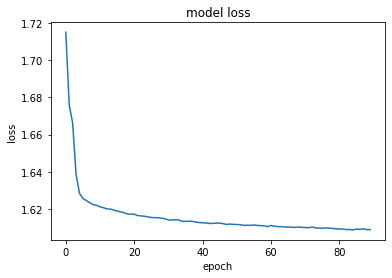

In [ ]:
#Plot the loss of the model during training
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Save and Evaluate LSTM stats out model
stats_out_model.save("stats_out_model_05_27")
stats_out_model.evaluate(X_test, y_test)

y_pred = stats_out_model.predict(X_test)
loss = stat_specific_loss(y_test, y_pred)
print(loss)

In [ ]:
#Evaluate stats out model in terms of fantasy points

y_pred = stats_out_model.predict(X_test)
y_pred_scores = scores_from_stats(y_pred)
y_test_scores = scores_from_stats(y_test)
loss = tf.keras.losses.mean_squared_error(y_test_scores, y_pred_scores)
print(loss)

In [ ]:
#Load and evaluate model
loaded_model = tf.keras.models.load_model("stats_out_model_05_27")
loaded_model.evaluate(X_test, y_test)

y_pred = loaded_model.predict(X_test)
print(y_pred)
stat_loss = stat_specific_loss(y_test, y_pred)
y_pred_scores = scores_from_stats(y_pred)
y_test_scores = scores_from_stats(y_test)
loss = tf.keras.losses.mean_squared_error(y_test_scores, y_pred_scores)
print(stat_loss)
print(loss)

620/620 [==============================] - 8s 5ms/step - loss: 6.3425 - accuracy: 0.6491


[6.3425116539001465, 0.6491051316261292]

In [ ]:
#Create LSTM end to end model (ie directly predicts fantasy points rather than
#stats for the 10th game)
end_end_model = LSTM_stats_model(10, 12, end_to_end = True)
end_end_model.summary()

#Transform the y_train (m, 12) array to a (m) array of fantasy scores from each
#10th game
y_train_scores = scores_from_stats(y_train)
#Train model
with tf.device('/device:GPU:0'):
  history3 = end_end_model.fit(X_train, y_train_scores, epochs=70, batch_size=64)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9, 20)]           0         
                                                                 
 normalization (Normalizatio  (None, 9, 20)            41        
 n)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 9, 128)            76288     
                                                                 
 lstm_5 (LSTM)               (None, 9, 128)            131584    
                                                                 
 lstm_6 (LSTM)               (None, 9, 64)             49408     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                           

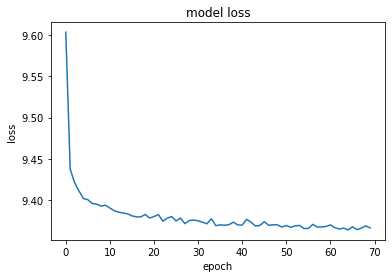

In [ ]:
#Plot the loss of the end to end model
plt.plot(history3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Save and Evaluate LSTM end to end model
end_end_model.save("end_end_model_05_27_2")
y_test_scores = scores_from_stats(y_test)
end_end_model.evaluate(X_test, y_test_scores)

y_pred = end_end_model.predict(X_test)
loss = tf.keras.losses.mean_squared_error(y_test_scores, y_pred)
print(loss)

INFO:tensorflow:Assets written to: end_end_model_05_27_2/assets


INFO:tensorflow:Assets written to: end_end_model_05_27_2/assets


620/620 [==============================] - 4s 5ms/step - loss: 9.2360 - accuracy: 0.0215
tf.Tensor([1158.5244   251.88367  261.36078 ...  388.33246  262.64703  249.92307], shape=(19835,), dtype=float32)


Flattened, deep learning model

In [ ]:
#Flatten the games into a (m, 180) array from a (m, 9, 20) array for predicting 
#the outcome of the 10th game using a deep neural network
#Predict either the stats or directly teh fantasy points of the 10th game
def flattened_Deep_Model(Tx, stats_mode = False):
  input = tf.keras.Input(shape=((Tx-1), 20))  

  #normalize the input and flatten it into a single array
  mid = normalize_layer(input)
  mid = tf.keras.layers.Flatten()(mid)

  #pass the input through 4 dense layers, each with batch normalization, dropout
  #and a RELU activation function
  mid = tf.keras.layers.Dense(512)(mid)
  mid = tf.keras.layers.BatchNormalization()(mid)
  mid = tf.keras.activations.relu(mid)
  mid = tf.keras.layers.Dropout(0.2)(mid)
  mid = tf.keras.layers.Dense(256)(mid)
  mid = tf.keras.layers.BatchNormalization()(mid)
  mid = tf.keras.activations.relu(mid)
  mid = tf.keras.layers.Dropout(0.2)(mid)
  mid = tf.keras.layers.Dense(64)(mid)
  mid = tf.keras.layers.BatchNormalization()(mid)
  mid = tf.keras.activations.relu(mid)
  mid = tf.keras.layers.Dropout(0.2)(mid)
  mid = tf.keras.layers.Dense(32, activation="relu")(mid)
  mid = tf.keras.layers.Dropout(0.2)(mid)
  mid = tf.keras.layers.Dense(16, activation="relu")(mid)

  #In the final layer, predict the stats of the 10th game
  out = tf.keras.layers.Dense(12, activation="linear")(mid)

  #optionally add a final layer for directly predicting fantasy scores
  if not stats_mode:
    out = tf.keras.layers.Dense(1, activation="linear")(mid)

  #declare the model
  model_flat = tf.keras.Model(inputs=input, outputs=out)

  #create an optimizer for the model
  opt = tf.keras.optimizers.Adam(lr=0.02, beta_1=0.9, beta_2=0.999, decay=0.01)

  #compile the model
  model_flat.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
  
  return model_flat

In [ ]:
#Create flat, deep stats out model
flat_stats_model = flattened_Deep_Model(10, stats_mode = True)
flat_stats_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 20)]           0         
                                                                 
 normalization (Normalizatio  (None, 9, 20)            41        
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 180)               0         
                                                                 
 dense (Dense)               (None, 512)               92672     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 512)               0     

In [ ]:
#Train the model
with tf.device('/device:GPU:0'):
  history2 = flat_stats_model.fit(X_train, y_train, epochs=150, batch_size=64)

Epoch 1/150
5889/5889 [==============================] - 60s 10ms/step - loss: 1.5908 - accuracy: 0.6059
Epoch 2/150
5889/5889 [==============================] - 59s 10ms/step - loss: 1.5666 - accuracy: 0.6069
Epoch 3/150
5889/5889 [==============================] - 62s 10ms/step - loss: 1.5606 - accuracy: 0.6055
Epoch 4/150
5889/5889 [==============================] - 63s 11ms/step - loss: 1.5604 - accuracy: 0.6055
Epoch 5/150
5889/5889 [==============================] - 66s 11ms/step - loss: 1.5581 - accuracy: 0.6054
Epoch 6/150
5889/5889 [==============================] - 65s 11ms/step - loss: 1.5563 - accuracy: 0.6051
Epoch 7/150
5889/5889 [==============================] - 64s 11ms/step - loss: 1.5567 - accuracy: 0.6049
Epoch 8/150
5889/5889 [==============================] - 60s 10ms/step - loss: 1.5555 - accuracy: 0.6042
Epoch 9/150
5889/5889 [==============================] - 59s 10ms/step - loss: 1.5558 - accuracy: 0.6053
Epoch 10/150
5889/5889 [==============================]

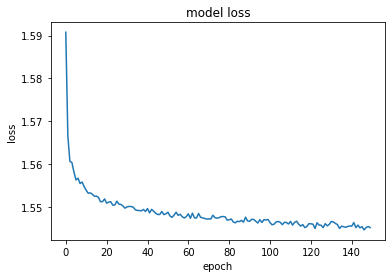

In [ ]:
#Plot the loss of the training
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Save and evaluate flat, deep stats out model
flat_stats_model.save("flat_stats_out_model_05_27")
flat_stats_model.evaluate(X_test, y_test)

y_pred = flat_stats_model.predict(X_test)
loss = stat_specific_loss(y_test, y_pred)
print(loss)

INFO:tensorflow:Assets written to: flat_stats_out_model_05_27/assets
620/620 [==============================] - 2s 3ms/step - loss: 1.5442 - accuracy: 0.5953
[5.96771768 2.35372414 3.82578922 1.00611616 2.13416311 2.59772203
 1.33511313 2.2250705  1.88879934 1.04187216 0.91243362 1.26703663]


In [ ]:
#Evaluate stats out model in terms of fantasy points
y_pred = flat_stats_model.predict(X_test)
y_pred_scores = scores_from_stats(y_pred)
y_test_scores = scores_from_stats(y_test)
loss = tf.keras.losses.mean_squared_error(y_test_scores, y_pred_scores)
print(loss)

tf.Tensor(188.080880262514, shape=(), dtype=float64)


In [ ]:
loaded_model2 = tf.keras.models.load_model("flat_stats_out_model_05_27")
loaded_model2.evaluate(normalized_X_test, y_test)


620/620 [==============================] - 2s 3ms/step - loss: 6.4170 - accuracy: 0.6492


[6.41702938079834, 0.6492059230804443]

Load and evaluate models

In [ ]:
#Navigate to relevant directory
%cd /content/gdrive/My Drive/freshman year/CS230/Notebooks/Final Project

#Declare relevant methods also outlined above
def scores_from_stats(stats):
  fantasy_score_arr = np.array([1,2,-1,1,1,-1,1,1,2,4,4,-2])
  score = np.zeros((stats.shape[0]))
  for i in range(stats.shape[0]):
    score[i] = np.dot(stats[i], fantasy_score_arr)
  score = np.squeeze(score)
  return score

def stat_specific_loss(y_true, y_hat):
  #shape of y_true and y_hat is (m, 12), calculates RMS
  loss = np.sqrt((1/y_true.shape[0]) * np.sum((y_true - y_hat) ** 2, axis = 0))
  return loss

#An array used to convert game stats to a fantasy score
fantasy_score_arr = np.array([0,1,0,0,0,0,2,-1,1,0,1,-1,1,1,2,4,4,-2,0,0])

#load in a test set and evaluate the models on that test set
test_set = np.load("test_set.npy")
X_test = np.zeros((test_set.shape[0], 9, 20))
y_test = np.zeros((test_set.shape[0]))
for i in range(test_set.shape[0]):
  X_test[i] = test_set[i].T[0:9, :]
  y_test[i] = np.squeeze(np.dot(test_set[i].T[9, :], fantasy_score_arr))



#load LSTM models
loaded_LSTM_model = tf.keras.models.load_model("stats_out_model_05_27")
loaded_LSTM_end_model = tf.keras.models.load_model("end_end_model_05_27_2")

#load deep, flat model
loaded_flat_model = tf.keras.models.load_model("flat_stats_out_model_05_27")

#both models take in (m, 9, 20) shaped numpy array X_test vectors

#create predictions for stats out LSTM model
y_pred1 = loaded_LSTM_model.predict(X_test)
y_pred_scores1 = scores_from_stats(y_pred1)

#create predictions for stats out, flat and deep NN
y_pred2 = loaded_flat_model.predict(X_test)
y_pred_scores2 = scores_from_stats(y_pred2)

#create predictions for end to end LSTM model
y_pred_3 = loaded_LSTM_end_model(X_test)

/content/gdrive/My Drive/freshman year/CS230/Notebooks/Final Project


In [ ]:
#define predictions and actual_vals using one of the three model predictions
predictions = y_pred_3
actual_vals = y_test

In [ ]:
num_test_examples = predictions.shape[0]
# Compute arrays representing l1 and l2 (MSE) losses per test example
l1_losses = np.abs(predictions - actual_vals)
l2_losses = np.square(predictions - actual_vals)
    
# Get total for l1 and l2 losses
total_l1_loss = np.sum(l1_losses)
total_l2_loss = np.sum(l2_losses)
 
# Get the average l1 and l2 loss per test example
avg_l1_loss = total_l1_loss/num_test_examples
avg_l2_loss = total_l2_loss/num_test_examples
 
# Get the median l1 and l2 losses over all test examples
median_l1_loss = np.median(np.abs(predictions - actual_vals))
median_l2_loss = np.median(np.square(predictions - actual_vals))
 
# Print out the found values above
print("Average l1 loss: " + str(avg_l1_loss))
print("Median l1 loss: " + str(median_l1_loss))
print("Average l2 loss: " + str(avg_l2_loss))
print("Median l2 loss: " + str(median_l2_loss))
 
# Graph histogram for l1 losses by percent in each category
plt.clf()
plt.hist(l1_losses, 10, weights=np.ones(len(l1_losses)) / len(l1_losses))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Histogram with l1 losses (abs fantasy point prediction errors)")
plt.show()
 
# Graph histogram for l2 losses by percent in each category
plt.clf()
plt.hist(l2_losses, 10, weights=np.ones(len(l2_losses)) / len(l2_losses))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Histogram with l2 losses (squared fantasy point prediction errors)")
plt.show()
 
# Graph histogram for l1 losses by percent in each category
plt.clf()
x = np.linspace(0,70,100)
y = 1*x+0
plt.plot(x, y, '-r', label='y=x (Perfect prediction line)')
plt.scatter(predictions, actual_vals, alpha = 0.2)
plt.title("Scatter Plot of Predictions on x-axis and corresponding actual values on y-axis")
plt.show()